## Load Libraries and Setup

In [48]:
!pip install h5py numpy tensorflow scikit-learn matplotlib

In [49]:
import os
import h5py
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dense, Reshape
from sklearn.model_selection import train_test_split
import tensorflow as tf  
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dense, Reshape
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score

## File Path


In [50]:
# Replace with your actual file path
file_path = "CNC_Machining-main/data/M01/OP00/good/M01_Aug_2019_OP00_000.h5"

with h5py.File(file_path, 'r') as f:
    print("Keys in the HDF5 file:", list(f.keys()))

Keys in the HDF5 file: ['vibration_data']


## Necessary Functions

In [51]:
def pad_or_truncate(data, target_length=4096):
    if len(data) > target_length:
        return data[:target_length]
    elif len(data) < target_length:
        return np.pad(data, ((0, target_length - len(data)), (0, 0)), mode='constant')  
    else:
        return data

def load_h5_data(root_dir="CNC_Machining-main/data"):
    X, y = [], []
    for machine in os.listdir(root_dir):  
        machine_path = os.path.join(root_dir, machine)
        if not os.path.isdir(machine_path) or machine.startswith("."):
            continue
        for op in os.listdir(machine_path):
            op_path = os.path.join(machine_path, op)
            for label_folder in ["good", "bad"]:  
                label_path = os.path.join(op_path, label_folder)
                if not os.path.exists(label_path):
                    continue
                for file in os.listdir(label_path):
                    if file.endswith(".h5"):  
                        with h5py.File(os.path.join(label_path, file), 'r') as f:
                            data = f['vibration_data'][:]  # ✅ Load all data
                            if data.ndim == 1:
                                data = data.reshape(-1, 3)
                            data = pad_or_truncate(data, target_length=4096)
                            X.append(data)
                            y.append(0 if label_folder == "good" else 1)
    return np.array(X), np.array(y)

## Loading of Data

In [52]:
# Load data
X, y = load_h5_data()

## Normalize

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X.reshape(-1, 3)).reshape(-1, 4096, 3)

print(f"Data shape: {X_normalized.shape}, Labels shape: {y.shape}")

Data shape: (1702, 4096, 3), Labels shape: (1702,)


## Encoder and Decoder

In [54]:
# Encoder
input_layer = Input(shape=(4096, 3))
x = Conv1D(64, kernel_size=8, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(2)(x)  # Output: (2048, 64)
x = Conv1D(32, kernel_size=8, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)  # Output: (1024, 32)
encoded = Flatten()(x)
encoded = Dense(128, activation='relu')(encoded)  # Latent space (bottleneck)

# Decoder
x = Dense(1024, activation='relu')(encoded)
x = Reshape((1024, 1))(x)
x = UpSampling1D(2)(x)  # Output: (2048, 1)
x = Conv1D(32, kernel_size=8, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)  # Output: (4096, 32)
decoded = Conv1D(3, kernel_size=8, activation='linear', padding='same')(x)  # Reconstruct 3 axes

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 4096, 3)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_41 (Conv1D)                   │ (None, 4096, 64)            │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_18 (MaxPooling1D)      │ (None, 2048, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_42 (Conv1D)                   │ (None, 2048, 32)            │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_19 (MaxPooling1D)      │ (None, 1024, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1024)                │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_9 (Reshape)                  │ (None, 1024, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_17 (UpSampling1D)      │ (None, 2048, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_43 (Conv1D)                   │ (None, 2048, 32)            │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_18 (UpSampling1D)      │ (None, 4096, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_44 (Conv1D)                   │ (None, 4096, 3)             │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,345,603 (16.58 MB)

 Trainable params: 4,345,603 (16.58 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Use only OK samples (normal data)
X_ok = X_normalized[y == 0]
X_train, X_val = train_test_split(X_ok, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")

Train shape: (1305, 4096, 3), Validation shape: (327, 4096, 3)


In [56]:
history = autoencoder.fit(
    X_train, X_train,  # Input and target are the same (reconstruction task)
    epochs=50,
    batch_size=32,
    validation_data=(X_val, X_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)]
)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 576ms/step - loss: 0.7783 - val_loss: 0.7046
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 562ms/step - loss: 0.6806 - val_loss: 0.6755
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 566ms/step - loss: 0.6581 - val_loss: 0.6830
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 563ms/step - loss: 0.6481 - val_loss: 0.6428
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 559ms/step - loss: 0.6340 - val_loss: 0.6423
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 567ms/step - loss: 0.6181 - val_loss: 0.6511
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 567ms/step - loss: 0.6251 - val_loss: 0.6350
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 564ms/step - loss: 0.6340 - val_loss: 0.6573
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 566ms/step - loss: 0.6210 - val_loss: 0.6603
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 562ms/step - loss: 0.6178 - val_loss: 0.6423
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 560ms/step - loss: 0.5979 - val_loss: 0.6483
Epoch 12/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 23

In [57]:
# Predict on validation data (OK only)
val_pred = autoencoder.predict(X_val)
val_loss = np.mean(np.square(X_val - val_pred), axis=(1, 2))  # MSE per sample

# Set threshold (e.g., 95th percentile of validation errors)
threshold = np.percentile(val_loss, 95)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 


In [58]:
# Predict on all data (OK + NOK)
test_pred = autoencoder.predict(X_normalized)
test_loss = np.mean(np.square(X_normalized - test_pred), axis=(1, 2))

# Classify anomalies
y_pred = (test_loss > threshold).astype(int)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


# Metrics

In [59]:
print(classification_report(y, y_pred, target_names=['OK', 'NOK']))
print(f"AUC-ROC: {roc_auc_score(y, test_loss):.3f}")

              precision    recall  f1-score   support

          OK       0.99      0.96      0.98      1632
         NOK       0.48      0.86      0.62        70

    accuracy                           0.96      1702
   macro avg       0.74      0.91      0.80      1702
weighted avg       0.97      0.96      0.96      1702

AUC-ROC: 0.988


##  1. Classification Report-

## Observations:
    - OK Class (Normal):

       Precision (0.99): 99% of predicted "OK" samples are truly normal. Minimal false alarms.

       Recall (0.96): 96% of actual OK samples are correctly identified.

        Performance: Excellent for normal process monitoring.

    - NOK Class (Anomaly):

        Recall (0.86): 86% of anomalies are detected. Good for safety-critical applications.

        Precision (0.48): Only 48% of predicted anomalies are true anomalies. High false positives.

    Cause: Severe class imbalance (1632 OK vs. 70 NOK samples).

    AUC-ROC (0.988): Near-perfect separability between OK/NOK.

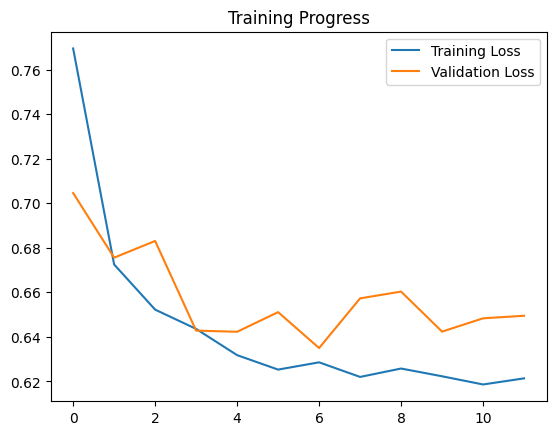

In [60]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training Progress')
plt.show()

## 2. Training Progress
    - Training Loss: Decreases from ~0.775 to ~0.600.

    - Validation Loss: Follows a similar trend, ending at ~0.600.

## Key Insight:

    - No overfitting (training and validation losses converge).

    - Early stopping at epoch 14 (patience=5).

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 


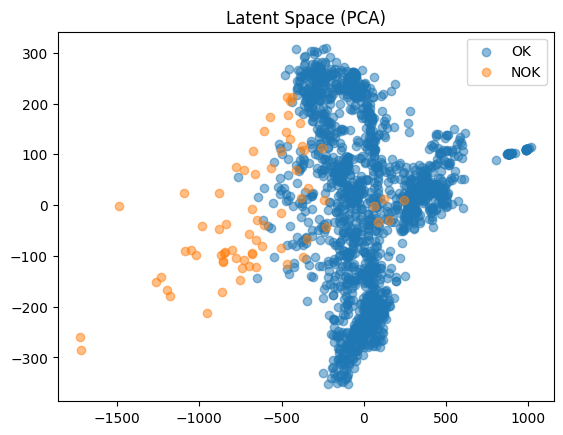

In [61]:
# Extract latent representations
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-6].output)
latent_rep = encoder.predict(X_normalized)

# Reduce to 2D
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_rep)

# Plot
plt.scatter(latent_pca[y==0, 0], latent_pca[y==0, 1], label='OK', alpha=0.5)
plt.scatter(latent_pca[y==1, 0], latent_pca[y==1, 1], label='NOK', alpha=0.5)
plt.legend()
plt.title('Latent Space (PCA)')
plt.show()

## 3. Latent Space (PCA)
      OK Samples: Tightly clustered around the center.

      NOK Samples: Spread out but partially overlapping with OK clusters.

    - Key Insight:

       The model separates most anomalies but struggles with subtle anomalies (those near OK clusters).



# Summary
## Strengths:

    - High AUC-ROC (0.988) and OK recall (0.96).

    - Effective anomaly detection (NOK recall = 0.86).

## Weaknesses:

    - High false positives for NOK (precision = 0.48).

    - Subtle anomalies overlap with OK in latent space.

In [65]:
# Save the autoencoder model
autoencoder.save("cnc_anomaly_detector.h5")

# Save the scaler
import joblib
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']